In [ ]:
import os
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from huggingface_hub.hf_api import HfFolder
from pathlib import Path
from pprint import pprint

import logging
logging.getLogger().setLevel(logging.WARNING)


Hf_token = "YOUR-TOKEN"
HfFolder.save_token(Hf_token)


In [2]:
# check if the enviroment is kaggle or local

DATASET_PATH = Path('/kaggle/input/')
if not DATASET_PATH.exists():
    DATASET_PATH = Path('.')
DATASET_PATH /= 'rai-bioml-2024'

### LLM inference

In [ ]:
from openai import OpenAI
from pydantic import BaseModel

class ResponseFormat(BaseModel):
    answer: bool
    # reasoning: str

class OPEN_AI_Server:
    def __init__(self, api_key: str=None):
        """
        Initialize the server with an OpenAI API key.
        """
        self.client = OpenAI(api_key=api_key)
        self.chat_context = []

    def add_system_context(self, message: str):
        """
        Add or update the system context in the chat history.
        If a system message exists, it will be updated; otherwise, it will be added.
        """
        if len(self.chat_context) == 0 or self.chat_context[0]["role"] != "system":
            self.chat_context.insert(0, {"role": "system", "content": message})
        else:
            self.chat_context[0]["content"] = message

    def add_user_context(self, message: str):
        """
        Add a user message to the chat context.
        """
        self.chat_context.append({"role": "user", "content": message})

    def add_model_context(self, message: str):
        """
        Add a model-generated message to the chat context.
        """
        self.chat_context.append({"role": "assistant", "content": message})

    def ask_question(self, message: str, add_context: bool = False,
                     temperature: float = 0.5, max_tokens: int = 100,
                     top_p: float = 1.0, model: str = "gpt-4o-mini"
                     ) -> ResponseFormat:
        """
        Send a user query to the OpenAI model and optionally update the chat context.

        Args:
            message (str): The user message to process.
            add_context (bool): Whether to update the chat context with the user query and model response.

        Returns:
            ResponseFormat: A structured response containing the answer and reasoning.
        """
        try:
            messages = self.chat_context + [{"role": "user", "content": message}]

            completion = self.client.beta.chat.completions.parse(
                model=model,
                messages=messages,
                max_tokens=max_tokens,
                temperature=temperature,
                top_p=top_p,
                logprobs=True,
                top_logprobs=3,
                response_format=ResponseFormat,
            )

            # if add_context:
                # self.add_model_context(f"Answer: {completion.answer}\nReasoning: {completion.reasoning}")

            return completion
        except Exception as e:
            return ResponseFormat(answer=None, reasoning=f"Error occured: {str(e)}")

    def clear_context(self):
        """
        Clear the chat context.
        """
        self.chat_context = []


In [4]:
server = OPEN_AI_Server()

server.add_system_context("You are a helpful assistant specialized in geography")

print(f"Server context: {server.chat_context}")
prompt = "Is London the capital of France?"
response = server.ask_question(prompt, temperature=0, max_tokens=50)
print(response)


Server context: [{'role': 'system', 'content': 'You are a helpful assistant specialized in geography'}]
ParsedChatCompletion[ResponseFormat](id='chatcmpl-Afo6iB0ZsbBcd3xEF9lrgzVMsV2Ye', choices=[ParsedChoice[ResponseFormat](finish_reason='stop', index=0, logprobs=ChoiceLogprobs(content=[ChatCompletionTokenLogprob(token='{"', bytes=[123, 34], logprob=0.0, top_logprobs=[TopLogprob(token='{"', bytes=[123, 34], logprob=0.0), TopLogprob(token='{', bytes=[123], logprob=-21.375)]), ChatCompletionTokenLogprob(token='answer', bytes=[97, 110, 115, 119, 101, 114], logprob=0.0, top_logprobs=[TopLogprob(token='answer', bytes=[97, 110, 115, 119, 101, 114], logprob=0.0), TopLogprob(token='ans', bytes=[97, 110, 115], logprob=-25.375), TopLogprob(token='an', bytes=[97, 110], logprob=-29.5)]), ChatCompletionTokenLogprob(token='":', bytes=[34, 58], logprob=0.0, top_logprobs=[TopLogprob(token='":', bytes=[34, 58], logprob=0.0), TopLogprob(token='":\n', bytes=[34, 58, 10], logprob=-21.1875), TopLogprob(tok

## Ontology access

In [5]:
from owlready2 import *
import rdflib
from enum import Enum

In [6]:
class AnnotationURIs(object):
    '''
    This class manages the most common ontology annotations
    '''

    def __init__(self):       
        self.mainLabelURIs = set()
        self.synonymLabelURIs = set()
        self.lexicalAnnotationURIs = set()      
                        
        #Main labels
        self.mainLabelURIs.add("http://www.w3.org/2000/01/rdf-schema#label")
        self.mainLabelURIs.add("http://www.w3.org/2004/02/skos/core#prefLabel")
        self.mainLabelURIs.add("http://purl.obolibrary.org/obo/IAO_0000111")
        self.mainLabelURIs.add("http://purl.obolibrary.org/obo/IAO_0000589")

        #synonyms or alternative names
        self.synonymLabelURIs.add("http://www.geneontology.org/formats/oboInOwl#hasRelatedSynonym")
        self.synonymLabelURIs.add("http://www.geneontology.org/formats/oboInOwl#hasExactSynonym")
        self.synonymLabelURIs.add("http://www.geneontology.org/formats/oboInOWL#hasExactSynonym")
        self.synonymLabelURIs.add("http://www.geneontology.org/formats/oboInOwl#hasRelatedSynonym")
        self.synonymLabelURIs.add("http://purl.bioontology.org/ontology/SYN#synonym")
        self.synonymLabelURIs.add("http://scai.fraunhofer.de/CSEO#Synonym")
        self.synonymLabelURIs.add("http://purl.obolibrary.org/obo/synonym")
        self.synonymLabelURIs.add("http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus.owl#FULL_SYN")
        self.synonymLabelURIs.add("http://www.ebi.ac.uk/efo/alternative_term")
        self.synonymLabelURIs.add("http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus.owl#Synonym")
        self.synonymLabelURIs.add("http://bioontology.org/projects/ontologies/fma/fmaOwlDlComponent_2_0#Synonym")
        self.synonymLabelURIs.add("http://www.geneontology.org/formats/oboInOwl#hasDefinition")
        self.synonymLabelURIs.add("http://bioontology.org/projects/ontologies/birnlex#preferred_label")
        self.synonymLabelURIs.add("http://bioontology.org/projects/ontologies/birnlex#synonyms")
        self.synonymLabelURIs.add("http://www.w3.org/2004/02/skos/core#altLabel")
        self.synonymLabelURIs.add("https://cfpub.epa.gov/ecotox#latinName")
        self.synonymLabelURIs.add("https://cfpub.epa.gov/ecotox#commonName")
        self.synonymLabelURIs.add("https://www.ncbi.nlm.nih.gov/taxonomy#scientific_name")
        self.synonymLabelURIs.add("https://www.ncbi.nlm.nih.gov/taxonomy#synonym")
        self.synonymLabelURIs.add("https://www.ncbi.nlm.nih.gov/taxonomy#equivalent_name")
        self.synonymLabelURIs.add("https://www.ncbi.nlm.nih.gov/taxonomy#genbank_synonym")
        self.synonymLabelURIs.add("https://www.ncbi.nlm.nih.gov/taxonomy#common_name")       

        #Alternative term       
        self.synonymLabelURIs.add("http://purl.obolibrary.org/obo/IAO_0000118")
        #Mouse anatomy
        #Lexically rich interesting
        self.lexicalAnnotationURIs.update(self.mainLabelURIs)
        self.lexicalAnnotationURIs.update(self.synonymLabelURIs)
        self.lexicalAnnotationURIs.add("http://www.w3.org/2000/01/rdf-schema#comment")
        self.lexicalAnnotationURIs.add("http://www.geneontology.org/formats/oboInOwl#hasDbXref")
        self.lexicalAnnotationURIs.add("http://purl.org/dc/elements/1.1/description")
        self.lexicalAnnotationURIs.add("http://purl.org/dc/terms/description")
        self.lexicalAnnotationURIs.add("http://purl.org/dc/elements/1.1/title")
        self.lexicalAnnotationURIs.add("http://purl.org/dc/terms/title")

        #Definition
        self.lexicalAnnotationURIs.add("http://purl.obolibrary.org/obo/IAO_0000115")
        #Elucidation
        self.lexicalAnnotationURIs.add("http://purl.obolibrary.org/obo/IAO_0000600")
        #has associated axiomm fol
        self.lexicalAnnotationURIs.add("http://purl.obolibrary.org/obo/IAO_0000602")
        #has associated axiomm nl
        self.lexicalAnnotationURIs.add("http://purl.obolibrary.org/obo/IAO_0000601")
        self.lexicalAnnotationURIs.add("http://www.geneontology.org/formats/oboInOwl#hasOBONamespace")

    def getAnnotationURIsForPreferredLabels(self):
        return self.mainLabelURIs
    
    def getAnnotationURIsForSymnonyms(self):
        return self.synonymLabelURIs

    def getAnnotationURIsForLexicalAnnotations(self):
        return self.lexicalAnnotationURIs


In [7]:
class Reasoner(Enum):
    HERMIT=0 #Not really adding the right set of entailments
    PELLET=1 #Slow for large ontologies
    STRUCTURAL=2  #Basic domain/range propagation
    NONE=3 #No reasoning

class OntologyAccess(object):

    def __init__(self, urionto, annotate_on_init=True):
        logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.WARNING)
        self.urionto = str(urionto)
        if annotate_on_init:
            self.loadOntology()
            self.indexAnnotations()

    def getOntologyIRI(self):
        return self.urionto

    def loadOntology(self, reasoner=Reasoner.NONE, memory_java='10240'):
        #Method from owlready
        self.onto = get_ontology(self.urionto).load()
        owlready2.reasoning.JAVA_MEMORY=memory_java
        owlready2.set_log_level(9)

        if reasoner==Reasoner.PELLET:
            try:
                with self.onto:  #it does add inferences to ontology

                    # Is this wrt data assertions? Check if necessary
                    # infer_property_values = True, infer_data_property_values = True
                    logging.info("Classifying ontology with Pellet...")
                    sync_reasoner_pellet() #it does add inferences to ontology
                    unsat = len(list(self.onto.inconsistent_classes()))
                    logging.info("Ontology successfully classified.")
                    if unsat > 0:
                        logging.warning("There are " + str(unsat) + " unsatisfiabiable classes.")
            except:
                logging.info("Classifying with Pellet failed.")

        elif reasoner==Reasoner.HERMIT:
                try:
                    with self.onto:  #it does add inferences to ontology
                        logging.info("Classifying ontology with HermiT...")
                        sync_reasoner() #HermiT doe snot work very well....
                        unsat = len(list(self.onto.inconsistent_classes()))
                        logging.info("Ontology successfully classified.")
                        if unsat > 0:
                            logging.warning("There are " + str(unsat) + " unsatisfiabiable classes.")
                except:
                    logging.info("Classifying with HermiT failed.")

        self.graph = default_world.as_rdflib_graph()
        logging.info("There are {} triples in the ontology".format(len(self.graph)))
        #self.graph = self.world.as_rdflib_graph()

    def getOntology(self):
        return self.onto

    def getClassByURI(self, uri):
        for cls in list(self.getOntology().classes()):
            if (cls.iri==uri):
                return cls
        return None

    def getClassByName(self, name):
        for cls in list(self.getOntology().classes()):
            if (cls.name.lower()==name.lower()):
                return cls
        return None

    def getEntityByURI(self, uri):
        for cls in list(self.getOntology().classes()):
            if (cls.iri==uri):
                return cls
        for prop in list(self.getOntology().properties()):
            if (prop.iri==uri):
                return prop
        return None

    def getEntityByName(self, name):
        for cls in list(self.getOntology().classes()):
            if (cls.name.lower()==name.lower()):
                return cls
        for prop in list(self.getOntology().properties()):
            if (prop.name.lower()==name.lower()):
                return prop
        return None

    def getClassObjectsContainingName(self, name):
        classes = []
        for cls in list(self.getOntology().classes()):
            if (name.lower() in cls.name.lower()):
                classes.append(cls)
        return classes

    def getClassIRIsContainingName(self, name):
        classes = []
        for cls in list(self.getOntology().classes()):
            if (name.lower() in cls.name.lower()):
                classes.append(cls.iri)
        return classes

    def getAncestorsURIsMinusClass(self,cls):
        ancestors_str = self.getAncestorsURIs(cls)
        ancestors_str.remove(cls.iri)
        return ancestors_str

    def getAncestorsURIs(self,cls):
        ancestors_str = set()
        for anc_cls in cls.ancestors():
            ancestors_str.add(anc_cls.iri)
        return ancestors_str

    def getAncestorsNames(self,cls):
        ancestors_str = set()
        for anc_cls in cls.ancestors():
            ancestors_str.add(anc_cls.name)
        return ancestors_str

    def getAncestors(self,cls):
        ancestors_str = set()
        for anc_cls in cls.ancestors():
            ancestors_str.add(anc_cls)
        return ancestors_str

    def getDescendantURIs(self,cls):
        descendants_str = set()
        for desc_cls in cls.descendants():
            descendants_str.add(desc_cls.iri)
        return descendants_str

    def getDescendantNames(self,cls):
        descendants_str = set()
        for desc_cls in cls.descendants():
            descendants_str.add(desc_cls.name)
        return descendants_str

    def getDescendants(self,cls):
        descendants_str = set()
        for desc_cls in cls.descendants():
            descendants_str.add(desc_cls)
        return descendants_str

    def getDescendantNamesForClassName(self, cls_name):
        cls = self.getClassByName(cls_name)
        descendants_str = set()
        for desc_cls in cls.descendants():
            descendants_str.add(desc_cls.name)
        return descendants_str

    def isSubClassOf(self, sub_cls1, sup_cls2):
        if sup_cls2 in sub_cls1.ancestors():
            return True
        return False

    def isSuperClassOf(self, sup_cls1, sub_cls2):
        if sup_cls1 in sub_cls2.ancestors():
            return True
        return False

    def getDomainURIs(self, prop):
        domain_uris = set()
        for cls in prop.domain:
            try:
                domain_uris.add(cls.iri)
            except AttributeError:
                pass
        return domain_uris

    def getDatatypeRangeNames(self, prop):
        range_uris = set()
        for cls in prop.range:
            range_uris.add(cls.name)  #datatypes are returned without uri
        return range_uris

    #Only for object properties
    def getRangeURIs(self, prop):
        range_uris = set()
        for cls in prop.range:
            try:
                range_uris.add(cls.iri)
            except AttributeError:
                pass
        return range_uris

    def getInverses(self, prop):
        inv_uris = set()
        for p in prop.inverse:
            inv_uris.add(p.iri)
        return inv_uris

    def getClasses(self):
        return self.getOntology().classes()

    def getDataProperties(self):
        return self.getOntology().data_properties()

    def getObjectProperties(self):
        return self.getOntology().object_properties()

    def getIndividuals(self):
        return self.getOntology().individuals()

    def getGraph(self):
        return self.graph

    def queryGraph(self, query):
        results = self.graph.query(query)
        return list(results)


    def getQueryForAnnotations(self, ann_prop_uri):
        return """SELECT DISTINCT ?s ?o WHERE {{
        {{
        ?s <{ann_prop}> ?o .
        }}
        UNION
        {{
        ?s <{ann_prop}> ?i .
        ?i <http://www.w3.org/2000/01/rdf-schema#label> ?o .
        }}
        }}""".format(ann_prop=ann_prop_uri)


    def indexAnnotations(self):
        annotation_uris = AnnotationURIs()
        self.entityToSynonyms = {}
        self.allEntityAnnotations = {}
        self.preferredLabels = {}
        self.populateAnnotationDicts(annotation_uris.getAnnotationURIsForSymnonyms(), self.entityToSynonyms)
        self.populateAnnotationDicts(annotation_uris.getAnnotationURIsForLexicalAnnotations(), self.allEntityAnnotations)
        self.populateAnnotationDicts(annotation_uris.getAnnotationURIsForPreferredLabels(), self.preferredLabels)

    def populateAnnotationDicts(self, annotation_uris, dictionary):
        for ann_prop_uri in annotation_uris:
            results = self.queryGraph(self.getQueryForAnnotations(ann_prop_uri))
            for row in results:
                try:
                    if row[1].language=="en" or row[1].language==None:
                        if not str(row[0]) in dictionary:
                            dictionary[str(row[0])]=set()
                        dictionary[str(row[0])].add(row[1].value)
                except AttributeError:
                    pass
        return None

    def getSynonymsNames(self, entity):
        if entity.iri not in self.entityToSynonyms: 
            return {}
        return self.entityToSynonyms[entity.iri]

    def getAnnotationNames(self, entity):
        if entity.iri not in self.allEntityAnnotations: 
            return {}
        return self.allEntityAnnotations[entity.iri]

    def getPrefferedLabels(self, entity):
        if entity.iri not in self.preferredLabels: 
            return {}
        return self.preferredLabels[entity.iri]


## Prompting

In [8]:
class OntologyEntryAttr:
    ## TODO: Add more attributes: direct children and parents
    def __init__(self, class_uri, onto: OntologyAccess, class_id=None):
        assert class_uri is not None or class_id is not None
        if class_uri is not None:
            self.class_id = onto.getClassByURI(class_uri)
        else:
            self.class_id = class_id
        assert self.class_id is not None
        self.annotation = {'class': self.class_id}
        self.onto:OntologyAccess = onto
        self.annotateEntry(onto)

    def annotateEntry(self, onto: OntologyAccess):
        logging.debug(f"Annotating {self.class_id}")
        self.annotation['children'] = onto.getDescendants(self.class_id)
        self.annotation['parents'] = onto.getAncestors(self.class_id)
        self.annotation['synonyms'] = onto.getSynonymsNames(self.class_id)
        self.annotation['names'] = onto.getAnnotationNames(self.class_id)

    def getAllEntetyNames(self):
        return self.annotation['names']

    def getSynonyms(self):
        return self.annotation['synonyms']
    
    def getChildren(self, skip_itself=True):
        result = self.annotation['children']
        if skip_itself:
            result = result.difference({self.class_id})
        return result

    def getParents(self, skip_itself=True):
        result = self.annotation['parents']
        if skip_itself:
            result = result.difference({self.class_id})
        return result

    def getParentsPreferredNames(self, skip_itself=True):
        labels = []
        for parent in self.getParents(skip_itself=skip_itself):
            preffered = self.onto.getPrefferedLabels(parent)
            if preffered:
                labels.append(preffered)
            else:
                labels.append({parent})
        return labels

    def getChildredPreferredNames(self, skip_itself=True):
        return [preffered if (preffered := self.onto.getPrefferedLabels(child)) else {child}
                for child in self.getChildren(skip_itself=skip_itself)]

    def __repr__(self):
        return str(self.annotation)

    def __str__(self):
        return str(self.annotation)

## Local matching

In [9]:
def dummy_prompt(src_entety:OntologyEntryAttr, tgt_entety:OntologyEntryAttr):
    return f"""
    **Task Description:**
    Given two entities from different ontologies with their names, parent relationships, and child relationships, determine if these concepts are the same:

    1. **Source Entity:**
    **All Entity names:** {src_entety.getAllEntetyNames()}
    **Parent Entity Namings:** {src_entety.getParentsPreferredNames()}
    **Child Entity Namings:** {src_entety.getChildredPreferredNames()}

    2. **Target Entity:**
    **All Entity names:** {tgt_entety.getAllEntetyNames()}
    **Parent Entity Namings:** {tgt_entety.getParentsPreferredNames()}
    **Child Entity Namings:** {tgt_entety.getChildredPreferredNames()}

    Write "Yes" if the entities refer to the same concepts, and "No" otherwise.
    """

def dummy_answer_extraction(response:str):
    """
    Returns 'Yes', 'No' or None based on the response, 
    Decision is made based on the presence of positive or negative words in the response
    """
    response = response.lower().strip()
    positive_words = ["yes", "yeah", "yep", "correct", "true"]
    negative_words = ["no", "nah", "nope", "wrong", "false"]
    is_positive = any([word in response for word in positive_words])
    is_negative = any([word in response for word in negative_words])
    if is_positive and not is_negative:
        return "Yes"
    elif is_negative and not is_positive:
        return "No"
    elif not is_positive and not is_negative:
        return None
    response = response.split('\n')
    for line in response:
        if "yes" in line:
            return "Yes"
        elif "no" in line:
            return "No"
    return None
    

### Extencive matching

In [10]:
def implication_prompt(source_entry, target_entry):
    """
    Creates a prompt asking if 'source_entry' implies 'target_entry'.
    Example: "It is [a/an] C, is it a D? Yes/No"
    """
    return f"It is [a/an] ${source_entry}$, is it a ${target_entry}$? Yes/No"

def equivalence_prompt(source_entry, target_entry):
    """
    Creates prompts for both directions to check if 'source_entry' implies 'target_entry' and vice versa.
    - Example: "It is [a/an] C, is it a D? Yes/No"
    - Example: "It is [a/an] D, is it a C? Yes/No"
    """
    prompt1 = implication_prompt(source_entry, target_entry)
    prompt2 = implication_prompt(target_entry, source_entry)
    return prompt1, prompt2

def synonyms_prompt(source_label, target_label):
    """
    Uses ontology to create prompts involving synonyms for C and D.
    Example: "It is [a/an] C-label2, is it a D-label3? Yes/No"
    """
    return f"It is [a/an] ${source_label}$, is it a ${target_label}$? Yes/No"

def transitivity_prompt(source_entry, intermediate_entry, target_entry):
    """
    Creates a transitivity prompt to check if 'source_entry' implies an intermediate entry,
    which then implies 'target_entry'.
    """
    return f"It is [a/an] ${source_entry}$, implies ${intermediate_entry}$, implies ${target_entry}$? Yes/No"

def hierarchical_equivalence_prompt(child1, parent1, child2, parent2):
    """
    Creates prompts to check bidirectional equivalence between two hierarchical entries.
    Example:
    - "Something is [a/an] C and [a/an] C', is it also [a/an] D and [a/an] D'? Yes/No"
    - "Something is [a/an] D and [a/an] D', is it also [a/an] C and [a/an] C'? Yes/No"
    """
    prompt1 = f"Something is [a/an] ${child1}$ and [a/an] ${parent1}$, is it also [a/an] ${child2}$ and [a/an] ${parent2}$? Yes/No"
    prompt2 = f"Something is [a/an] ${child2}$ and [a/an] ${parent2}$, is it also [a/an] ${child1}$ and [a/an] ${parent1}$? Yes/No"
    return prompt1, prompt2

## Add context

In [11]:
RESULTS_DIR = Path("./results")

def dummy_prompt(src_entety:OntologyEntryAttr, tgt_entety:OntologyEntryAttr):
    return f"""
    Given two entities from different ontologies with their names and parent relationships, determine if these concepts are the same:

    1.Source Entity:
    All Entity names: {src_entety.getAllEntetyNames()}

    2.Target Entity:
    All Entity names: {tgt_entety.getAllEntetyNames()}
    
    Response with True or False
    """
    # Parent Entity Namings: {src_entety.getParentsPreferredNames()}
    # Parent Entity Namings: {tgt_entety.getParentsPreferredNames()}
    
def extract_answer_openai(response):
    if isinstance(response, ResponseFormat):
        return response.answer
    return response.choices[0].message.parsed.answer
    
def save_results(results, subname=""):
    with open(RESULTS_DIR / f"llm_oracle_results{subname}.txt", 'w') as file:
        for line in results:
            file.write(line + "\n")
    return

def read_pairs(path):
    pairs = []
    with open(path, 'r') as file:
        for line in file:
            first = line.split("|")[0].strip()
            second = line.split("|")[1].strip()
            pairs.append((first, second))
    return pairs


In [12]:
SET_NAME = 'anatomy'
SOURCE_ONTOLOGY = 'mouse'
TARGET_ONTOLOGY = 'human'

src_onto_path = DATASET_PATH / f'{SET_NAME}/{SOURCE_ONTOLOGY}.owl'
tgt_onto_path = DATASET_PATH / f'{SET_NAME}/{TARGET_ONTOLOGY}.owl'

onto_src = OntologyAccess(src_onto_path, annotate_on_init=True)
onto_tgt = OntologyAccess(tgt_onto_path, annotate_on_init=True)

* Owlready2 * Creating new ontology human <rai-bioml-2024/anatomy/human.owl#>.
* Owlready2 * ADD TRIPLE rai-bioml-2024/anatomy/human.owl http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2002/07/owl#Ontology
* Owlready2 *     ...loading ontology human from rai-bioml-2024/anatomy/human.owl...


* Owlready2 * Reseting property oboInOwl.ObsoleteProperty: new triples are now available.
* Owlready2 * Reseting property oboInOwl.hasRelatedSynonym: new triples are now available.
* Owlready2 * Reseting property oboInOwl.hasDefaultNamespace: new triples are now available.
* Owlready2 * Reseting property oboInOwl.savedBy: new triples are now available.
* Owlready2 * Reseting property oboInOwl.hasDate: new triples are now available.


* Owlready2 *     ...8 properties found: ObsoleteProperty, UNDEFINED_part_of, label, hasRelatedSynonym, hasDefaultNamespace, savedBy, hasDate, hasDefinition


In [13]:
llm_oracle = OPEN_AI_Server()

INITIALIZATION_MESSAGE = "You are a proffesional ontology matcher. You need to answer different questions about mathcing ontologies. Be precise, please"
llm_oracle.add_system_context(INITIALIZATION_MESSAGE)
config = {'temperature': 0, 'max_tokens': 50, 'top_p': 0.3, "model":"gpt-4o-mini"}

In [14]:
pairs_file = DATASET_PATH / f"{SET_NAME}/bioml-{SET_NAME}-oasystem_mappings_to_ask_oracle_user_llm.txt"
with open(pairs_file, 'r') as file:
    lines = file.readlines()
    
logging.getLogger().setLevel(logging.WARN)

FileNotFoundError: [Errno 2] No such file or directory: 'rai-bioml-2024/anatomy/bioml-anatomy-oasystem_mappings_to_ask_oracle_user_llm.txt'

In [ ]:
from tqdm import tqdm
import time
from typing import Callable

start = time.time()

results = []
tokens_usage = []

prompt_function: Callable = dummy_prompt

for i, row in enumerate(lines):
    if i % 100 == 0 and i > 0:
        print(f"Processed {i} rows in {time.time()-start} seconds")
        save_results(results, f"_{i}")
        
    source = row.split('|')[0]
    target = row.split('|')[1]
    print(f"Processing {source} -> {target}")
    try:
        prompt = prompt_function(OntologyEntryAttr(source, onto_src), OntologyEntryAttr(target, onto_tgt))
    except AssertionError:
        prompt = prompt_function(OntologyEntryAttr(target, onto_src), OntologyEntryAttr(source, onto_tgt))

    response = llm_oracle.ask_question(prompt, **config)
    resp = extract_answer_openai(response)
    input_tokens = response.usage.prompt_tokens
    output_tokens = response.usage.completion_tokens
    
    log_probs = response.choices[0].logprobs.model_dump()['content']

    for pred_tocken_info in log_probs:
        if pred_tocken_info['token'].strip() not in ['true', 'false']:
            continue
        logprobs = pred_tocken_info['top_logprobs']
        positive_logprob = max([e['logprob'] for e in logprobs if e['token'].strip() == 'true'], default=np.nan)
        negative_logprob = max([e['logprob'] for e in logprobs if e['token'].strip() == 'false'], default=np.nan)
        break
    else:
        positive_logprob = np.nan
        negative_logprob = np.nan
        
        
    confidence = np.nanmax([np.exp(positive_logprob), np.exp(negative_logprob)])
    
    tokens_usage.append((input_tokens, output_tokens), confidence)
    print(f"{source}|{target}|{resp}|{confidence}")
    results.append(f"{source}|{target}|{resp}|{confidence}")
    break


Processing http://human.owl#NCI_C32658 -> http://mouse.owl#MA_0002684
http://human.owl#NCI_C32658|http://mouse.owl#MA_0002684|False|0.7772971261297498


Mean input tockens: 168.7
Mean output tockens: 5.0
Total input tockens: 11975
Total output tockens: 355


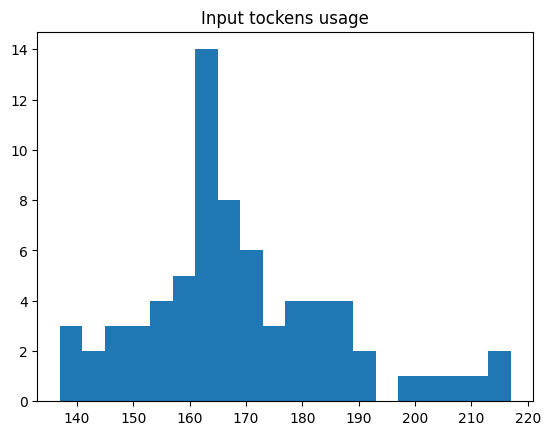

In [39]:
save_results(results, subname="_ncit-doid-gpt-4o-mini")

tokens_usage = np.array(tokens_usage)
print(f"Mean input tockens: {tokens_usage[:,0].mean():.1f}")
print(f"Mean output tockens: {tokens_usage[:,1].mean():.1f}")
print(f"Total input tockens: {tokens_usage[:,0].sum()}")
print(f"Total output tockens: {tokens_usage[:,1].sum()}")

plt.hist(tokens_usage[:,0], bins=20); plt.title("Input tockens usage");

In [15]:
def prompt_with_hierarchy(src_entety:OntologyEntryAttr, tgt_entety:OntologyEntryAttr):
    return f"""
    Given two entities from different ontologies with their names, parent relationships, and child relationships, determine if these concepts are the same:

    1. Source Entity:
    All Entity names: {src_entety.getAllEntetyNames()}
    Parent Entity Namings: {src_entety.getParentsPreferredNames()}
    Child Entity Namings: {src_entety.getChildredPreferredNames()}

    2. Target Entity:
    All Entity names: {tgt_entety.getAllEntetyNames()}
    Parent Entity Namings: {tgt_entety.getParentsPreferredNames()}
    Child Entity Namings: {tgt_entety.getChildredPreferredNames()}

    Response with True or False
    """
    
def prompt_only_with_parents(src_entety:OntologyEntryAttr, tgt_entety:OntologyEntryAttr):
    return f"""
    Given two entities from different ontologies with their names and parent relationships, determine if these concepts are the same:

    1. Source Entity:
    All Entity names: {src_entety.getAllEntetyNames()}
    Parent Entity Namings: {src_entety.getParentsPreferredNames()}

    2. Target Entity:
    All Entity names: {tgt_entety.getAllEntetyNames()}
    Parent Entity Namings: {tgt_entety.getParentsPreferredNames()}

    Response with True or False
    """
    
def prompt_only_names(src_entety:OntologyEntryAttr, tgt_entety:OntologyEntryAttr):
    return f"""
    Given two entities from different ontologies with their names, determine if these concepts are the same:

    1. Source Entity:
    All Entity names: {src_entety.getAllEntetyNames()}

    2. Target Entity:
    All Entity names: {tgt_entety.getAllEntetyNames()}
    
    Response with True or False
    """
    
def prompt_only_with_children(src_entety:OntologyEntryAttr, tgt_entety:OntologyEntryAttr):
    return f"""
    Given two entities from different ontologies with their names and child relationships, determine if these concepts are the same:

    1. Source Entity:
    All Entity names: {src_entety.getAllEntetyNames()}
    Child Entity Namings: {src_entety.getChildredPreferredNames()}

    2. Target Entity:
    All Entity names: {tgt_entety.getAllEntetyNames()}
    Child Entity Namings: {tgt_entety.getChildredPreferredNames()}

    Response with True or False
    """

def prompt_synonyms_subsumption(source_entry :OntologyEntryAttr, target_entry:OntologyEntryAttr):
    """
    Creates a prompt to determine if one entity's synonyms suggest it subsumes the other.
    """
    return f"""
    **Task Description:**
    Given two entities with their synonyms, determine if one entity subsumes the other.

    1. **Source Entity Synonyms:** {source_entry.getSynonyms()}
    2. **Target Entity Synonyms:** {target_entry.getSynonyms()}

    Response with True or False
    """
    
def prompt_one_name_one_synonym(source_entry :OntologyEntryAttr, target_entry:OntologyEntryAttr):
    """
    Creates a prompt to determine if one entity's synonyms suggest it subsumes the other.
    """
    return f"""
    **Task Description:**
    Given two entities with their synonyms, determine if one entity subsumes the other.

    1. **Source Entity Synonyms:** {max(list(source_entry.getSynonyms()), key=len)}
    2. **Target Entity Names:** {max(list(target_entry.getAllEntetyNames()), key=len)}

    Response with True or False
    """

EXP_NAME_TO_PROMPT_FUNCTION = {
    "only_names": prompt_only_names,
    "with_hierarchy": prompt_with_hierarchy,
    "only_with_parents": prompt_only_with_parents,
    "only_with_children": prompt_only_with_children,
    "synonyms_subsumption": prompt_synonyms_subsumption,
    "one_name_one_synonym": prompt_one_name_one_synonym
}             
                          

In [16]:
def plot_usage_histograms(tokens_usage, do_plot=True, do_print=True, suptitle=""):
    tokens_usage = np.array(tokens_usage)
    if do_print:
        print(f"Mean input tockens: {tokens_usage[:,0].mean():.1f}")
        print(f"Mean output tockens: {tokens_usage[:,1].mean():.1f}")
        print(f"Total input tockens: {tokens_usage[:,0].sum()}")
        print(f"Total output tockens: {tokens_usage[:,1].sum()}")
        
    if do_plot:
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        fig.suptitle(suptitle)
        axes[0].hist(tokens_usage[:,0], bins=20); axes[0].set_title("Input tockens usage")
        axes[1].hist(tokens_usage[:,1], bins=20); axes[1].set_title("Output tockens usage");
        axes[2].hist(tokens_usage[:,2], bins=50); axes[2].set_title("Confidence distribution");
        plt.show()
    return

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def get_gt_pairs(gt_positive_pairs_path):
    gt_positive_pairs = pd.read_csv(gt_positive_pairs_path, sep='\t', header=None)
    try:
        gt_positive_pairs.columns = ["Source", "Target", "Label"]
    except Exception as e:
        gt_positive_pairs.columns = ["Source", "Target", '=',  'Label', 'notes']
    return gt_positive_pairs

def get_pred_pairs(pred_results_path):
    pred_pairs = pd.read_csv(pred_results_path, sep='|', header=None)
    try:
        pred_pairs.columns = ["Source", "Target", "Prediction", "Confidence"]
    except Exception as e:
        pred_pairs.columns = ["Source", "Target", "Prediction"]
    return pred_pairs


def extend_results_with_labels(df, gt_df):
    df["Label"] = False
    for idx, row in gt_df.iterrows():
        source = row['Source']
        target = row['Target']
        mask = (df['Source'] == source) & (df['Target'] == target) | (df['Source'] == target) & (df['Target'] == source)
        df.loc[mask, 'Label'] = True
    df['Type'] = df.apply(lambda x: 'TP' if x['Label'] and x['Prediction'] else 'TN' if not x['Label'] and not x['Prediction'] else 'FP' if not x['Label'] and x['Prediction'] else 'FN', axis=1)
    return df

def analyze_results(df, print_results=True, plot_confusion_matrix=True, subtitle='', save_path=None):
    accuracy = accuracy_score(df['Label'], df['Prediction'])
    precision = precision_score(df['Label'], df['Prediction'])
    recall = recall_score(df['Label'], df['Prediction'])
    f1 = f1_score(df['Label'], df['Prediction'])
    conf_matrix = confusion_matrix(df['Label'], df['Prediction'])

    if print_results:
        print(f"Accuracy: {accuracy:.2f}")
        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"F1 Score: {f1:.2f}")
        
    if plot_confusion_matrix:
        plt.figure(figsize=(4, 4))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'{subtitle}')
        if save_path:
            plt.savefig(save_path)
        plt.show()
        
    return accuracy, precision, recall, f1, conf_matrix


def get_pred_gt_df(dataset_path, set_name, model, exp_type):
    gt_positive_pairs_path = f"{dataset_path}/{set_name}/refs_equiv/full.tsv"
    pred_results_path = RESULTS_DIR / f"llm_oracle_results_{set_name}_all_{model}_{exp_type}.txt"
    gt_df = get_gt_pairs(gt_positive_pairs_path)
    pred_df = get_pred_pairs(pred_results_path)
    pred_df = extend_results_with_labels(pred_df, gt_df)
    return pred_df, gt_df

Processing Lines only_names:   0%|          | 0/398 [00:00<?, ?it/s]

Processing Lines only_names: 100%|██████████| 398/398 [00:47<00:00,  8.32it/s]


Results for only_names
Mean input tockens: 166.0
Mean output tockens: 5.0
Total input tockens: 66053.0
Total output tockens: 1990.0


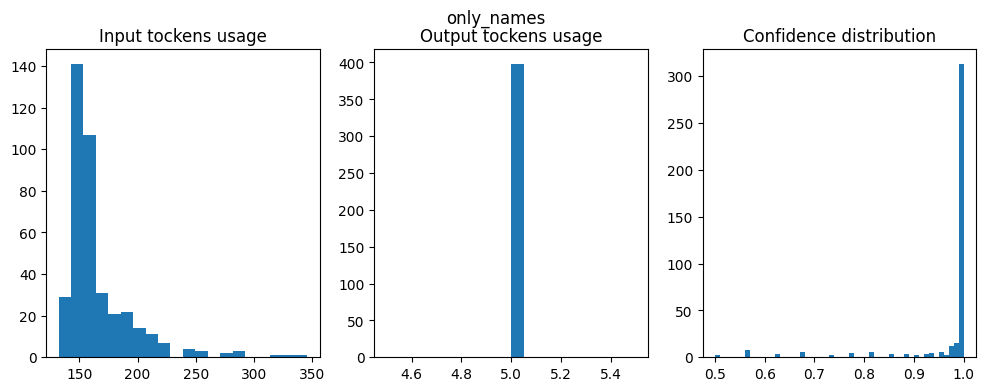

Accuracy: 0.83
Precision: 0.86
Recall: 0.93
F1 Score: 0.89


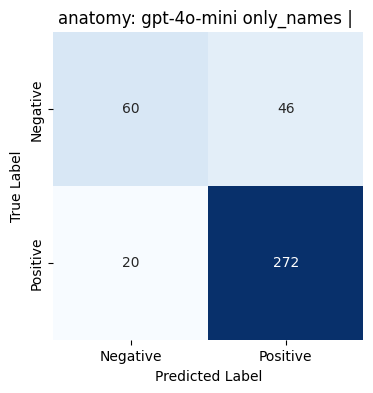

Processing Lines with_hierarchy: 100%|██████████| 398/398 [00:45<00:00,  8.70it/s]


Results for with_hierarchy
Mean input tockens: 307.2
Mean output tockens: 5.0
Total input tockens: 122253.0
Total output tockens: 1990.0


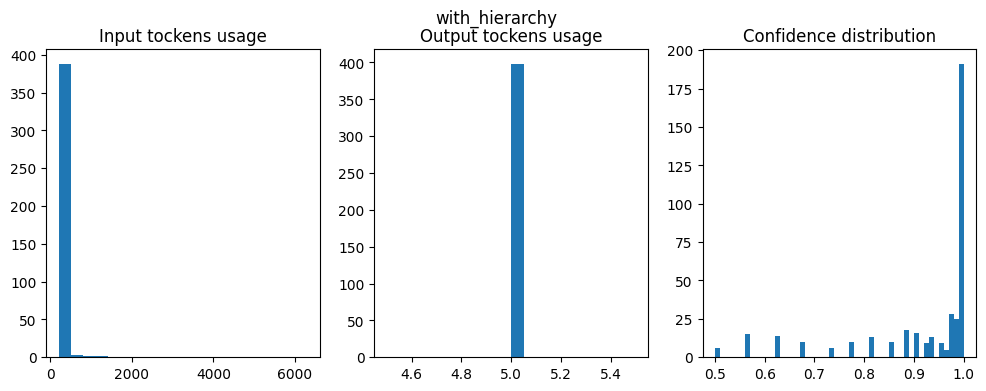

Accuracy: 0.64
Precision: 0.88
Recall: 0.59
F1 Score: 0.70


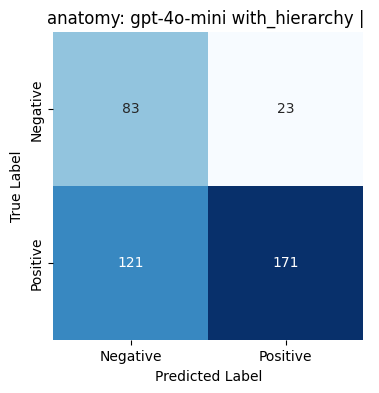

Processing Lines only_with_parents: 100%|██████████| 398/398 [00:43<00:00,  9.21it/s]


Results for only_with_parents
Mean input tockens: 241.9
Mean output tockens: 5.0
Total input tockens: 96263.0
Total output tockens: 1990.0


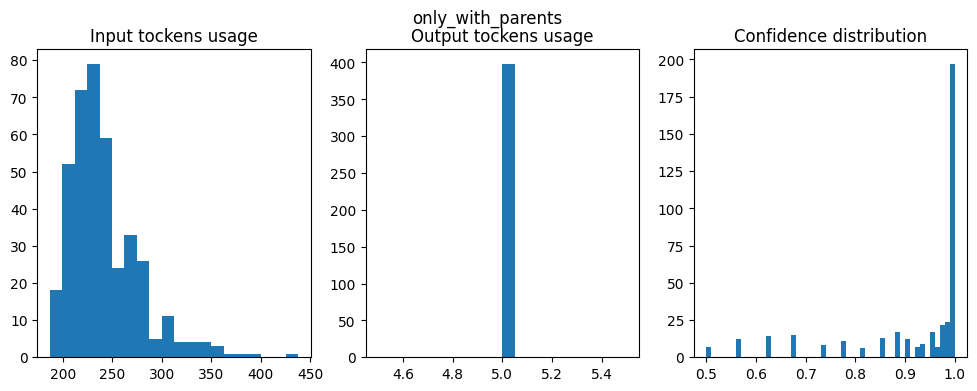

Accuracy: 0.67
Precision: 0.87
Recall: 0.64
F1 Score: 0.74


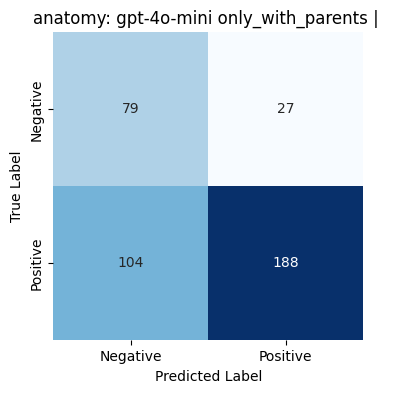

Processing Lines only_with_children: 100%|██████████| 398/398 [00:44<00:00,  8.94it/s]


Results for only_with_children
Mean input tockens: 229.8
Mean output tockens: 5.0
Total input tockens: 91442.0
Total output tockens: 1990.0


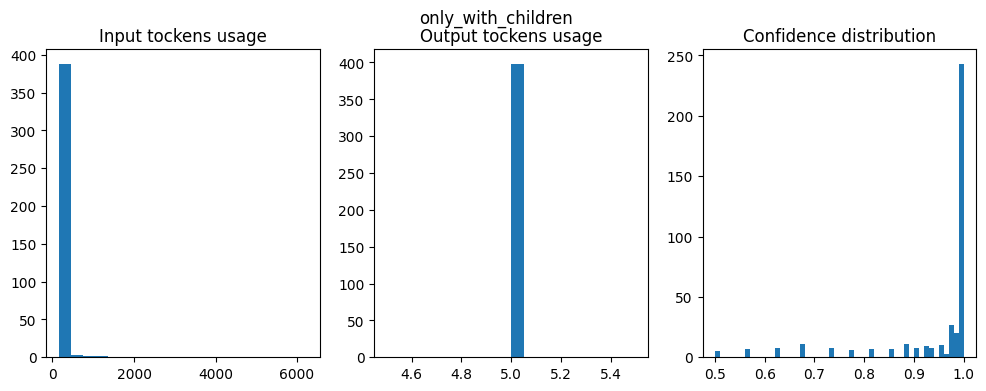

Accuracy: 0.74
Precision: 0.86
Recall: 0.76
F1 Score: 0.81


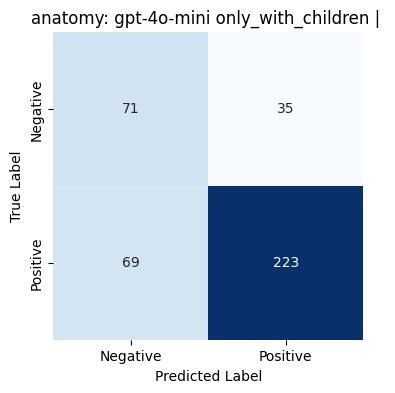

Processing Lines synonyms_subsumption: 100%|██████████| 398/398 [00:44<00:00,  8.89it/s]


Results for synonyms_subsumption
Mean input tockens: 150.7
Mean output tockens: 5.0
Total input tockens: 59966.0
Total output tockens: 1990.0


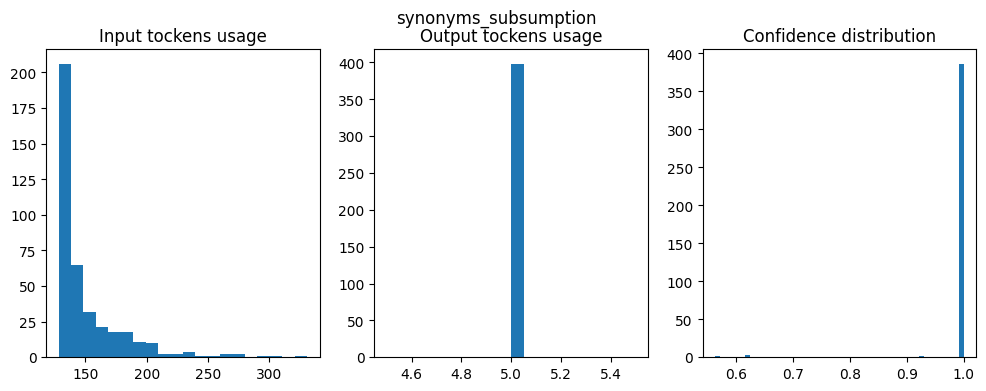

Accuracy: 0.33
Precision: 0.76
Recall: 0.13
F1 Score: 0.22


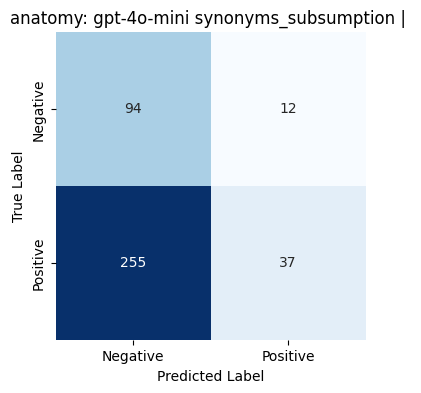

Processing Lines one_name_one_synonym: 100%|██████████| 398/398 [00:55<00:00,  7.15it/s]


Results for one_name_one_synonym
Mean input tockens: 161.5
Mean output tockens: 5.0
Total input tockens: 64264.0
Total output tockens: 1990.0


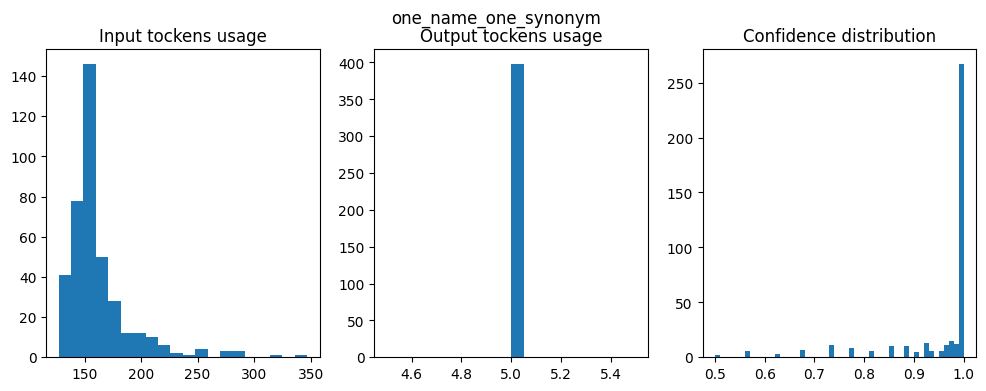

Accuracy: 0.78
Precision: 0.85
Recall: 0.86
F1 Score: 0.85


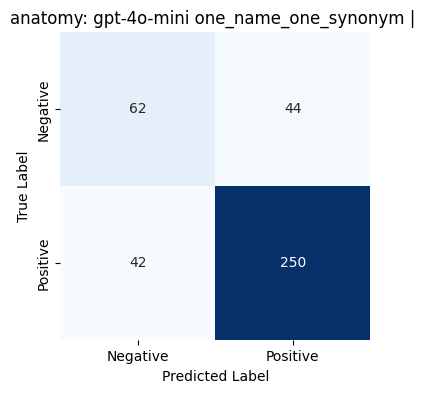

In [21]:

from concurrent.futures import ThreadPoolExecutor, as_completed

def process_line(line, llm_oracle:OPEN_AI_Server, config, onto_src, onto_tgt, one_more_time=True, prompt_function=dummy_prompt):
    """
    Process a single line: generate a prompt, send it to the LLM, and extract the response.
    """
    try:
        source = line.split('|')[0]
        target = line.split('|')[1]
        
        try:
            prompt = prompt_function(OntologyEntryAttr(source, onto_src), OntologyEntryAttr(target, onto_tgt))
        except AssertionError:
            prompt = prompt_function(OntologyEntryAttr(target, onto_src), OntologyEntryAttr(source, onto_tgt))

        response = llm_oracle.ask_question(prompt, **config)
        resp = extract_answer_openai(response)


        try:
            input_tokens = response.usage.prompt_tokens
            output_tokens = response.usage.completion_tokens
            log_probs = response.choices[0].logprobs.model_dump()['content']
        except:
            log_probs = []
            input_tokens = -1
            output_tokens = -1

        
        for pred_tocken_info in log_probs:
            if pred_tocken_info['token'].strip() not in ['true', 'false']:
                continue
            logprobs = pred_tocken_info['top_logprobs']
            positive_logprob = max([e['logprob'] for e in logprobs if e['token'].strip() == 'true'], default=np.nan)
            negative_logprob = max([e['logprob'] for e in logprobs if e['token'].strip() == 'false'], default=np.nan)
            break
        else:
            positive_logprob = np.nan
            negative_logprob = np.nan
            
        confidence = np.nanmax([np.exp(positive_logprob), np.exp(negative_logprob)])
        token_usage = (input_tokens, output_tokens, confidence)
        result = f"{source}|{target}|{resp}|{confidence}"
        return result, token_usage
    
    except Exception as e:
        try:
            return f"Error processing line: {line} | {response} | {str(e)}", (input_tokens, output_tokens)
        except:
            if one_more_time:
                return process_line(line, llm_oracle, config, onto_src, onto_tgt, one_more_time=False)
            return f"Error processing line: {line} | No Responce | {str(e)}", (-1, 0)


def parallel_process_lines(lines, llm_oracle, config, onto_src, onto_tgt, max_workers=4, 
                           CURRENT_EXP_TYPE=dummy_prompt, 
                           model = "gpt-4o-mini"):
    """
    Process lines in parallel, with progress tracking using tqdm.
    """
    results = []
    tokens_usage = []
    confidences = []
    
    if CURRENT_EXP_TYPE not in EXP_NAME_TO_PROMPT_FUNCTION:
        print(f"Invalid experiment type: {CURRENT_EXP_TYPE}")
        return []
    prompt_function = EXP_NAME_TO_PROMPT_FUNCTION[CURRENT_EXP_TYPE]
    
    MAX_WORKERS = 6

    NUM_ROWS = len(lines)

    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        future_to_line = {
            executor.submit(process_line, line, llm_oracle, config, onto_src, onto_tgt, 
                            prompt_function=prompt_function,
                            ): line
            for line in lines[:NUM_ROWS]
        }

        for future in tqdm(as_completed(future_to_line), total=len(future_to_line), desc=f"Processing Lines {CURRENT_EXP_TYPE}"):
            result, token_usage = future.result()
            results.append(result)
            tokens_usage.append(token_usage)
            
    save_results(results, subname=f"_{SET_NAME}_all_{model}_{CURRENT_EXP_TYPE}")
    return results, tokens_usage, confidences


MODEL = "gpt-4o-mini"

pairs_file = DATASET_PATH / f"{SET_NAME}/bioml-{SET_NAME}-oasystem_mappings_to_ask_oracle_user_llm.txt"
with open(pairs_file, 'r') as file:
    lines = file.readlines()

from tqdm import tqdm
for CURRENT_EXP_NAME in EXP_NAME_TO_PROMPT_FUNCTION:
    results, tokens_usage, confidences = parallel_process_lines(lines, llm_oracle, config, onto_src, onto_tgt,
                                                                CURRENT_EXP_TYPE=CURRENT_EXP_NAME, model=MODEL)
    print(f"Results for {CURRENT_EXP_NAME}")
    plot_usage_histograms(tokens_usage, do_plot=True, do_print=True, suptitle=CURRENT_EXP_NAME)
    predictions, gt_df = get_pred_gt_df(DATASET_PATH, SET_NAME, MODEL, CURRENT_EXP_NAME)
    
    save_path = RESULTS_DIR / f"confusion_matrix_{SET_NAME}_{MODEL}_{CURRENT_EXP_NAME}.png"
    analyze_results(predictions, print_results=True, plot_confusion_matrix=True, subtitle=f'{SET_NAME}: {MODEL} {CURRENT_EXP_NAME} | ', save_path=save_path)
    print("\n\n\n")


rai-bioml-2024/anatomybioml-anatomy-oasystem_mappings_to_ask_oracle_user_llm.txt
rai-bioml-2024/anatomy/bioml-anatomy-oasystem_mappings_to_ask_oracle_user.txt

## Results analysis

In [ ]:
exp_type = "only_names"
gpt_mini_predictions, gt_df = get_pred_gt_df(DATASET_PATH, SET_NAME, MODEL, exp_type)
analyze_results(gpt_mini_predictions, print_results=True, plot_confusion_matrix=True, subtitle=f'{SET_NAME}: {MODEL} {exp_type} | ');

## analyze false predictions

In [ ]:
def print_results_entry(res_df, pair_type='FP', idx=0):
    source_uri = res_df[res_df['Type'] == pair_type].iloc[idx]['Source']
    target_uri = res_df[res_df['Type'] == pair_type].iloc[idx]['Target']

    source_entry = OntologyEntryAttr(source_uri, onto_src)
    target_entry = OntologyEntryAttr(target_uri, onto_tgt)

    print(f"Processing pair {idx} of type {pair_type}")
    pprint("Source Entry:\n")
    pprint(source_entry.annotation)
    pprint("Target Entry:\n")
    pprint(target_entry.annotation)

    print(f"Parent of Source Concept: {source_entry.getParentsPreferredNames()}")
    print(f"Parent of Target Concept: {target_entry.getParentsPreferredNames()}")

In [ ]:
exp_type = "only_names"
res_df, _ = get_pred_gt_df(DATASET_PATH, SET_NAME, model='gpt-4o-mini', exp_type)

In [123]:
print_results_entry(res_df, pair_type='FP', idx=0)

Processing pair 0 of type FP
'Source Entry:\n'
{'children': {entry.615179},
 'class': entry.615179,
 'names': {'albinism, oculocutaneous,  iia 7', 'OCA7'},
 'parents': {phenotypicSeries.PS203100, owl.Thing, entry.615179},
 'synonyms': {'OCA7'}}
'Target Entry:\n'
{'children': {ORDO.Orphanet_352745},
 'class': ORDO.Orphanet_352745,
 'names': {'Oculocutaneous albinism type 7', 'OCA7'},
 'parents': {owl.Thing,
             ORDO.Orphanet_352745,
             ORDO.Orphanet_C001,
             ORDO.Orphanet_377788},
 'synonyms': {'OCA7'}}
Parent of Source Concept: [{'Oculocutaneous albinism'}, {owl.Thing}]
Parent of Target Concept: [{owl.Thing}, {'disease'}, {'clinical entity'}]


In [22]:
!ls results |grep ".png"

confusion_matrix_anatomy_gpt-4o-mini_one_name_one_synonym.png
confusion_matrix_anatomy_gpt-4o-mini_only_names.png
confusion_matrix_anatomy_gpt-4o-mini_only_with_children.png
confusion_matrix_anatomy_gpt-4o-mini_only_with_parents.png
confusion_matrix_anatomy_gpt-4o-mini_synonyms_subsumption.png
confusion_matrix_anatomy_gpt-4o-mini_with_hierarchy.png
